<font size="5">Analysis of Airbnb Data</font>

Business Questions:  

1. Which features of Airbnb properties are the best indicators for lodging price?
2. Does the presence of dogs and cats influence price? 
3. How well can we predict price?

The analyis uses combined Airbnb data from Seattle and Boston. 

See the README.md file for additional information.


In [86]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
%matplotlib inline

# Read airbnb datasets
df_seattle = pd.read_csv('./data/seattle/listings.csv')
df_boston = pd.read_csv('./data/boston/listings.csv')

# Combine the two airbnb datasets
df = pd.concat([df_seattle, df_boston])
df.reset_index(inplace=True, drop=True)

# show the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7403 entries, 0 to 7402
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                7403 non-null   int64  
 1   listing_url                       7403 non-null   object 
 2   scrape_id                         7403 non-null   int64  
 3   last_scraped                      7403 non-null   object 
 4   name                              7403 non-null   object 
 5   summary                           7083 non-null   object 
 6   space                             5777 non-null   object 
 7   description                       7403 non-null   object 
 8   experiences_offered               7403 non-null   object 
 9   neighborhood_overview             4956 non-null   object 
 10  notes                             3822 non-null   object 
 11  transit                           5179 non-null   object 
 12  thumbn

<font size="4">Data Preparation:</font>

The main function for data cleaing is 'clean_data(df)'; see the doumentation string of the function for the steps involved. The 'price' is used as the response variable. For the explanatory variables, missing numerical data is imputed with the mean of the feature and categorical data is converted using one-hot encoding. Most of the categorical variables are included to obtain a full picture, only some were removed after inspection, such as 'zipcode', 'calendar_last_scraped', or 'neighbourhood'. Also removed were descriptive and identifier columns such as 'summary', 'space', 'name', 'listing_url', or 'host_id'.

In [87]:
# Define small functions for data preparation used in the function
# clean_data(df) below.

def check_chars(s):
    """
    This function finds tags for prices or percentages in strings.
    
    INPUT
    s - A string
    
    OUTPUT
    True / False - Boolean indicating the existance of '$' and/or '%' in s
    """    
    c=re.search('[\$\%]', str(s))
    if c:
        return True
    else:
        return False


def find_digits(s):
    """
    This function extracts float and int numbers in strings.
    
    INPUT
    s - A string
    
    OUTPUT
    p - Digits as floatingpoint number
    s - The input string if no digits where detected
    """
    if check_chars(s):    
        p=re.findall('\d+\.\d+', s)
        d=re.findall('\d+', s)
        if p:
            return float(p[0])
        elif d:
            return float(d[0])
        else:
            return float('nan')    
    else:
        return s

def split_amenities(s):
    """
    This function splits and cleans the 'amenities' entries.
    
    INPUT
    s - A string
    
    OUTPUT
    split_lst - A list of the string s splitted at ','
    """
    s_r = re.sub('[} " {]','',s)
    split_lst=s_r.split(',')
    return split_lst

def create_lst_amenities(col):
    """
    This function returns a set of all occuring amenities
    
    INPUT
    col - A Series object
    
    OUTPUT
    lst_amenities - A set of the levels in col
    """
    lst_amenities=[]
    for i in range(col.shape[0]):
        lst_split=split_amenities(col.iloc[i])
        for am in lst_split:
            lst_amenities.append(am)
        
    return set(lst_amenities)


def create_X_amenities(df):
    """
    This function creates a DataFrame for the levels of 'amenities'.
    
    INPUT
    df - A DataFrame object including the feature amenities
    
    OUTPUT
    X_amenities - A DataFrame object with a column for each level of 
                  amenities
    """
    feature_lst=list(create_lst_amenities(df.amenities))
    feature_lst.remove('')
    feature_lst.remove('translationmissing:en.hosting_amenity_50')
    feature_lst.remove('translationmissing:en.hosting_amenity_49')
    
    X_amenities = pd.DataFrame(0, index=np.arange(df.shape[0]), columns=feature_lst)

    for var in feature_lst:
        for idx in range(df.shape[0]):
            if var in list(split_amenities(df.iloc[idx]['amenities'])):
                X_amenities.iloc[idx][var]=1
    
    return X_amenities



In [88]:
# Prepare the data
def clean_data(df):
    """
    INPUT
    df - Pandas DataFrame 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when
        predicting the response
    y - The corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no price
    2. Drop all the columns with only NaN values
    3. Drop columns with no variability
    4. Convert string-digits into float numbers
    2. Create X as all the columns that are not the price column
    3. Create y as the price column
    5. For each null numeric value in X, impute the value with the mean 
       value of the column
    6. Create dummy columns for all the categorical variables in X, 
       including dummy variables for all the levels in amenities
    """
    
    # Drop rows with no price
    df = df.dropna(subset=['price'], axis = 0)    
    
    # Create a separate DataFrame for the levels of the feature amenities.
    X_amenities = create_X_amenities(df)
    
    # Drop columns with NaN for all the values
    col_na_lst = list(df.columns[df.isnull().all()])
    df.drop(columns=col_na_lst, inplace=True)
    
    # Drop columns with no variablility
    for col in df.columns:
        if df[col].value_counts().shape[0]==1:
            df.drop(columns=[col], inplace=True)
    
    # Pull a list of the columns names of the categorical variables
    cat_cols_lst = df.select_dtypes(include=['object']).columns
    
    # Convert digits in strings into float numbers
    for col in cat_cols_lst:
        df[col]=df[col].apply(find_digits)
     
    # Pull a list of the columns names of the numerical variables in df
    num_cols_list_df = df.select_dtypes(include=['float', 'int']).columns
    
    # Create explanatory and response variables and fill missing numerical 
    # values with the mean of the column
    fill_mean = lambda col: col.fillna(col.mean())
    y=df['price'].copy()
    X_cat=df[['state','host_has_profile_pic','host_is_superhost','host_identity_verified',
            'is_location_exact','property_type','room_type','bed_type','instant_bookable',
            'host_response_time','require_guest_profile_picture',
            'require_guest_phone_verification']].copy()

    X_num = df[num_cols_list_df].apply(fill_mean)            
         
    # Create the dummy variables for X_cat
    cat_cols_lst_X = X_cat.select_dtypes(include= ['object']).columns
    X_dummy=pd.get_dummies(X_cat, columns = cat_cols_lst_X, dummy_na = False)

    # Drop individual columns
    X_dummy.drop(columns=['property_type_Other', 'state_wa'], inplace=True)
   
    X_num.drop(columns=['latitude','longitude','price','weekly_price',
                        'monthly_price','id','scrape_id','host_id'], inplace=True)    
    
    # Combine all the features into X
    X_combined = pd.concat([X_num, X_amenities, X_dummy],axis = 1, join='inner')
    
    # Normalize the data
    X_combined_norm = (X_combined-X_combined.min())/(X_combined.max()-X_combined.min())
    
    return X_combined_norm, y
    
# Use the function to create X and y
X, y = clean_data(df)


<font size="4">Modeling and Evaluation:</font>

For modeling the property prices, Ridge regression is applied. To find the optimal model, cutoffs are applied to drop sparse features.

In [89]:
def features_cutoff(X, y, cutoffs, alpha_ridge, split_frac):
    """
    INPUT:
    X - A dataframe object holding all the explanatory variables of interest
    y - A series object holding the response variables

    OUTPUT:
    coefs_df - A dataframe object holding the coefficients found for the optimal model
    best_cutoff - The optimal cutoff
    best_num_feats - The optimal number of features
    lm_model - The best model

    This function calcultes the test and train scores as a function of the cutoffs applied, in order to find
    the optimal model. The cutoffs determine the minimum of the allowed sum of the values in a column of X.
    """
    num_feats=[]
    r2_scores_val=[]
    r2_scores_train=[]
    for cutoff in cutoffs:
        # Reduced X matrix
        X_reduced = X.iloc[:, np.where((X.sum()>cutoff)==True)[0]]
        num_feats.append(X_reduced.shape[1])
        
        # Split the data into train and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X_reduced, y, test_size = split_frac, random_state = 42)
        
        # Instantiate, Fit, Predict, Score
        lm_model_cut = Ridge(alpha=alpha_ridge, normalize=False)
        lm_model_cut.fit(X_train, y_train)
        y_val_preds = lm_model_cut.predict(X_val)
        y_train_preds = lm_model_cut.predict(X_train)
        r2_scores_val.append(r2_score(y_val, y_val_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
    
    # Plot the scores against the number of features
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(num_feats, r2_scores_val, label = 'Val', alpha=.5)
    ax.plot(num_feats, r2_scores_train, label = 'Train', alpha=.5)
    ax.set_xlabel('Number of features')
    ax.set_ylabel('Score')
    ax.legend()
    
    # Obtain the best cutoff and the best number of features
    best_cutoff = cutoffs[np.argmax(r2_scores_val)]
    best_num_feats = num_feats[np.argmax(r2_scores_val)]
    
    # Find the coefficients for the best cutoff
    lm_model = Ridge(alpha=alpha_ridge, normalize=False)
    X_reduced = X.iloc[:, np.where((X.sum()>best_cutoff)==True)[0]]
    X_train, X_val, y_train, y_val = train_test_split(X_reduced, y, test_size = split_frac, random_state = 42)
    lm_model.fit(X_train, y_train)
    columns_best = X_train.columns
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = columns_best
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df['coefs'] = lm_model.coef_
    coefs_df = coefs_df.sort_values('abs_coefs', ascending = False)
    
    return coefs_df, best_cutoff, best_num_feats, lm_model, columns_best
    


The best cutoff is: 140
The best number of features is: 90


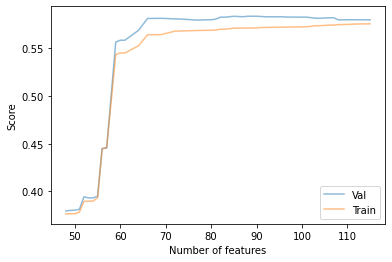

In [90]:
# Split the data into train and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, random_state = 42)
# set parameters
alpha_ridge = 0.1
split_frac = 0.3
# Find the optimal model based on cuttoffs for the sum of a features values
cutoffs = list(range(1, 101, 1)) + list(range(105,305,5)) + list(range(350,2050,50))
coefs_df, best_cutoff, best_num_feats, lm_model, columns_best = features_cutoff(X_train_val, y_train_val, cutoffs, alpha_ridge,split_frac)
coefs_sort = coefs_df.sort_values('abs_coefs', ascending = False)
print('The best cutoff is:', best_cutoff)
print('The best number of features is:', best_num_feats)

The best cutoff is found to be 140, which corresponds to including the 90 features with the largest sum of values. The findings of the project are based on these 90 features.

<font size="4">Business Questions:</font>

<font size="3">1) First business question </font>

Which features of Airbnb properties are the best indicators for price? To answer this question the 20 most influential features are visualized.

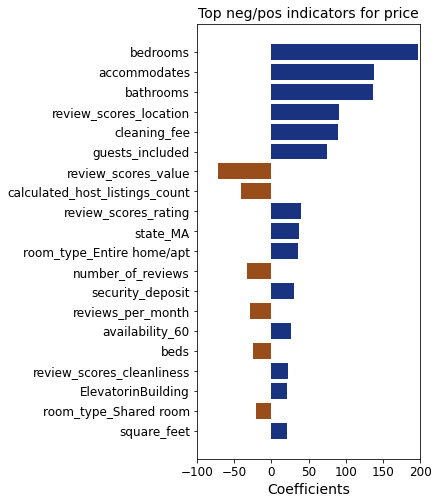

In [91]:
# Plot the top neg/pos coefficients found for the optimal model
fig, ax = plt.subplots(figsize=(4,8))

coef_names = coefs_sort.iloc[:20]['est_int']
y_pos = np.arange(len(coef_names))
coefs = coefs_sort.iloc[:20]['coefs']

ax.barh(y_pos, coefs, align='center', color=(coefs > 0).map({True: (0.1, 0.2, 0.5), False: (0.6, 0.3, 0.1)}))
ax.set_yticks(y_pos)
ax.set_yticklabels(coef_names, fontsize=12)
ax.invert_yaxis()  # Labels top-to-bottom
ax.set_xlabel('Coefficients', fontsize=14)
ax.set_title('Top neg/pos indicators for price',fontsize=14)
plt.xticks(fontsize=12)
ax.set_xlim([-100, 200])

plt.show()


The red bars show features with a negative influence on price, the blue bars with a positive influence. The best indicator for a low price is therefore 'review scores value', whereas the best indicator for a high price is 'bedrooms'.

<font size="3">2) Second business question </font>

Does the presence of dogs and cats influence price? 

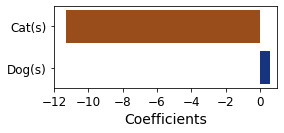

The regresion coefficients are 0.5659246938733323 for Dog(s) and -11.28147117100151 for Cat(s).


In [92]:
# Plot the coefficients found for Dog(s) and Cat(s) for the optimal model
fig, ax = plt.subplots(figsize=(4,1.5))

coef_dogs = coefs_sort[coefs_sort['est_int']=='Dog(s)']['coefs'].values[0]
coef_cats = coefs_sort[coefs_sort['est_int']=='Cat(s)']['coefs'].values[0]
idx_dogs = coefs_sort[coefs_sort['est_int']=='Dog(s)'].index[0]
idx_cats = coefs_sort[coefs_sort['est_int']=='Cat(s)'].index[0]

coef_names_cats_dogs = coefs_sort.loc[[idx_cats,idx_dogs],:]['est_int']
y_pos = np.arange(len(coef_names_cats_dogs))
coefs_cats_dogs = coefs_sort.loc[[idx_cats,idx_dogs],:]['coefs']

ax.barh(y_pos, coefs_cats_dogs, align='center', color=(coefs_cats_dogs > 0).map({True: (0.1, 0.2, 0.5), False: (0.6, 0.3, 0.1)}))
ax.set_yticks(y_pos)
ax.set_yticklabels(coef_names_cats_dogs, fontsize=12)
ax.invert_yaxis()  # Labels top-to-bottom
ax.set_xlabel('Coefficients', fontsize=14)
plt.xticks(fontsize=12)
ax.set_xlim([-12, 1])

plt.show()

# Print the coefficients found for Dog(s) and Cat(s)
print('The regresion coefficients are {} for Dog(s) and {} for Cat(s).'.format(coef_dogs, coef_cats))


From the coefficients we can conclude that dogs are a weak indicator for high price, whereas cats clearly are an indicator for low price.

Why are places with cats cheaper? This question is difficult to answer but we might get some hints from the correlation of the variables 'Cat(s)' and 'Dog(s)' with other variables.

In [93]:
# We first obtain the correlation matrix and grep the columns for dogs and cats
corr_matrix = X.corr()
corr_dogs = corr_matrix['Dog(s)']
corr_cats = corr_matrix['Cat(s)']

In [94]:
# We calculate the difference in the correlations between cats and dogs
corr_combined_cats = pd.concat([corr_dogs, corr_cats], axis=1, join='inner')
corr_combined_cats['Cat(s)-Dog(s)'] = corr_combined_cats['Cat(s)']- corr_combined_cats['Dog(s)']
# show the sorted correlation matrix for the difference in correlations
vars_cat = corr_combined_cats.sort_values(by=['Cat(s)-Dog(s)'],ascending=False)[1:8]
vars_cat

,Dog(s),Cat(s),Cat(s)-Dog(s)
Otherpet(s),0.077706,0.128629,0.050924
property_type_Yurt,-0.003868,0.040513,0.044381
room_type_Shared room,-0.032607,0.009556,0.042163
SuitableforEvents,-0.011929,0.027992,0.039921
room_type_Private room,0.085483,0.122373,0.036890
SmokingAllowed,0.039417,0.068513,0.029095
property_type_House,0.100623,0.129424,0.028801


The sorted column 'Cat(s)-Dog(s)' reveals which features the 'Cat(s)' variable correlates most with relative to the 'Dog(s)' variable. Let's do the same for the 'Dog(s)' by using 'Dog(s)-Cat(s)':


In [95]:
# We calculate the difference in the correlations between dogs and cats
corr_combined_dogs = pd.concat([corr_dogs, corr_cats], axis=1, join='inner')
corr_combined_dogs['Dog(s)-Cat(s)'] = corr_combined_dogs['Dog(s)']- corr_combined_dogs['Cat(s)']
# show the sorted correlation matrix for the difference in correlations
vars_dog = corr_combined_dogs.sort_values(by=['Dog(s)-Cat(s)'],ascending=False)[1:8]
vars_dog

,Dog(s),Cat(s),Dog(s)-Cat(s)
PetsAllowed,0.160526,0.018437,0.142089
Petsliveonthisproperty,0.700447,0.602150,0.098297
IndoorFireplace,0.092430,0.034685,0.057745
property_type_Tent,0.043416,-0.007459,0.050874
room_type_Entire home/apt,-0.073194,-0.123531,0.050338
property_type_Camper/RV,0.047785,-0.000759,0.048544
Family/KidFriendly,0.029870,-0.017207,0.047077


There are some differences that are interesting. Cats relate to variables such as 'Shared room', 'Yurt', 'Suitable for events', and 'Smoking allowed'. Dogs on the other hand relate to variables such as 'Indoor Fireplace', 'Family Friendly', 'CableTV', and 'Camper'. It is likely that the porperties with cats or dogs are different in average and that these variables express this indirectly. Therefore the cats do not necessarily cause low prices, the variable 'Cat(s)' rather catches a hidden feature that often comes together with cats. 

<font size="3">3) Third business question</font>

How well can we predict price?
    
To answer this question the model is **deployed** and the R-squared score is calculated for predicting lodging prices on the test set.

In [96]:
# Make predictions on the test set and evaluate the R-squared score
X_test_red=X_test.loc[:,columns_best]
y_test_preds = lm_model.predict(X_test_red)
r2_test = r2_score(y_test, y_test_preds)
print('The R-squared score for the test set is:', r2_test)

The R-squared score for the test set is: 0.5807287467762039


The R-squared score is 0.58, which indicates that 58% of the variability in the price is explained by explanatory variables such as amenities, room/property type or state. The model therefore explains the variability of the prices only moderately well. Here only a linear regression model was applied, other model might explain the variability better.